## Measuring Magnetic Constant Experiment - Optimize
### Load Libraries

In [8]:
# For scientific computing
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.stats import chi2

# For plotting
import matplotlib.pyplot as plt

## Plot of I^2 vs m
Equation is written as:
$$I^2 = (\frac{2 \pi dg}{\mu_0 l}) * m$$
where $(\frac{2 \pi dg}{\mu_0 l})$ is slope

d is 
$$ d = \frac{Dc}{2b} + barDiameter $$

Then $\mu_0$ will be
$$\mu_0 = \frac{2 \pi d g}{(slope)l} $$

slope= (1003.9 ± 8.9)
intercept = (-0.82 ± 0.35)
mu0_hat = 9.7E-07 H/m
alpha_mu0 = 3.3E-08 H/m


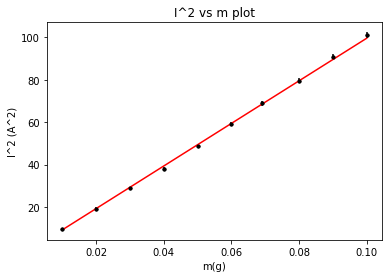

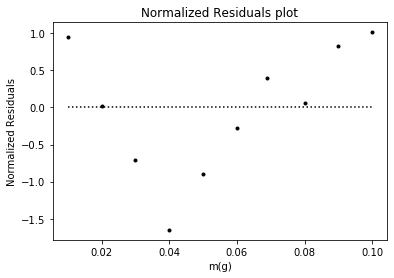

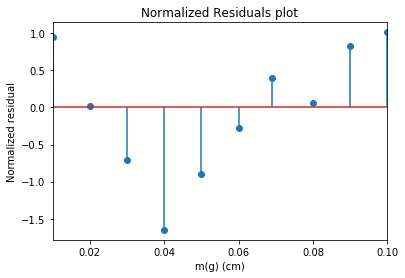

degree of freedom dof = 8
chisq_min = 6.9
Cumulative probability = 0.449890
Significance: 0.550110
chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [4.0, 12.0], so our model is within the 1*sigma range
Our model is accepted


In [35]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global string for labelling
labely = "I^2 (A^2)"
labelx = "m(g)"

#global constants
D = 53.45 - 50.85 #cm
b = 215.0 #cm distanc from mirror to scale
l = 29.10 #cm # top conductor
c = 22.0 # cm 
g = 980.665 #cm/s^2
barDiam = 0.325 #cm
d0 = D * c / (2 * b)
d = d0 + barDiam

alpha_D = 0.283
alpha_b = 1.0
alpha_l = 0.05
alpha_c = 0.05
alpha_barDiam = 0.005
alpha_d0 = d0 * np.sqrt( (alpha_D/D)**2 + (alpha_c/c)**2 + (alpha_b/b)**2)
alpha_d = np.sqrt( alpha_d0**2 + alpha_barDiam**2 )


I, m = np.genfromtxt(f"data/2020-11-03-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')

Isq = I**2
#uncertainties
alpha_I = 0.002 * I + 0.05
# alpha_Isq = Isq * np.sqrt(abs(2 * alpha_I / I))
alpha_Isq = alpha_I * (abs(2 * I))
alpha_m = 0.0005

#number of parameters
n = 2

# --------------------------------------------------------------------------------------------------
# Fitting
# --------------------------------------------------------------------------------------------------

#inputs
x = m
y = Isq
alpha_x = alpha_m
alpha_y = alpha_Isq
N = len(x)

def myFunc(x, m, b):
    return m * x + b

pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[1, 0],
                       sigma=alpha_y,
                       absolute_sigma=True) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

# printing/plotting/calculation result ------------------------------------------

# Show optimized fit parameters and uncertainties
slope = p0_opt
intercept = p1_opt

alpha_slope = alpha_p0
alpha_intercept = alpha_p1

print(f"slope= ({p0_opt:.1f} ± {alpha_p0:.1f})")
print(f"intercept = ({p1_opt:.2f} ± {alpha_p1:.2f})")

mu0_hat = 2 * np.pi * d * g / (slope * l) * 10 ** (-5)
alpha_m0 = mu0_hat * np.sqrt( (alpha_d/d)**2 + (alpha_slope/slope)**2 + (alpha_l/l)**2)
print(f"mu0_hat = {mu0_hat:.1E} H/m")
print(f"alpha_mu0 = {alpha_m0:.1E} H/m")
#print(f"mu0 = ({mu0_hat:.2f} ± {alpha_m0:.2f}) H/m")



# Plot data
plt.plot(x, y, 'k.')
plt.plot(x, myFunc(x, p0_opt, p1_opt), 'r-')
plt.errorbar(x, y, yerr=alpha_y, fmt='k.')
plt.xlabel(f'{labelx}')
plt.ylabel(f'{labely}')
plt.title(f'I^2 vs m plot')
plt.show()

# Plot the residuals in a separate figure
plt.plot(x, (y - myFunc(x, p0_opt, p1_opt))/alpha_y, 'k.')
plt.plot([np.min(x), np.max(x)], [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format
plt.xlabel(f"{labelx}")
plt.ylabel('Normalized Residuals')
plt.title(f'Normalized Residuals plot')
plt.show()

# --------------------------------------------------------------------------------------------------
# Chi-square analysis
# --------------------------------------------------------------------------------------------------
# Compute and display chi-squared minimum
dof = len(x) - n
res = y - myFunc(x, p0_opt, p1_opt)
normres = res/alpha_y
chisq = np.sum(normres**2)
reduced_chisq = chisq / dof
cdf = chi2.cdf(chisq, dof) # Compute the probability of getting this fit result

# plotting result
plt.stem(x, normres, use_line_collection=True)
plt.xlabel(f'{labelx} (cm)')
plt.ylabel('Normalized residual')
plt.title(f'Normalized Residuals plot')
plt.xlim(np.min(x), np.max(x))
plt.show()

# printing result -------------------------------------------------------------------------
print(f"degree of freedom dof = {dof}")
print(f"chisq_min = {chisq:.1f}")
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

if (chisq > dof - np.sqrt(2 * dof) and chisq < dof + np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is within the 1*sigma range")
    print("Our model is accepted")
else:
    print(f"chisq_min is not within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is not within the 1*sigma range")
    print(f"null hypothesis is rejected; our model is not accepted.")